In [ ]:
!pip install -U sympy
!pip install -U transformers


<ipython-input-2-efdac20ac1ca>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['poem_text'] = train_data['poem_text'].astype(str)
<ipython-input-2-efdac20ac1ca>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['poem_text'] = test_data['poem_text'].astype(str)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab 

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Training Loss: 1.2403, Validation Loss: 1.0054, Epoch Time: 304.04 seconds
Epoch 2/10, Training Loss: 0.7302, Validation Loss: 0.6956, Epoch Time: 302.63 seconds
Epoch 3/10, Training Loss: 0.5374, Validation Loss: 0.6903, Epoch Time: 302.59 seconds
Epoch 4/10, Training Loss: 0.4331, Validation Loss: 0.6611, Epoch Time: 302.69 seconds
Epoch 5/10, Training Loss: 0.3450, Validation Loss: 0.7130, Epoch Time: 302.71 seconds
Epoch 6/10, Training Loss: 0.2729, Validation Loss: 0.7726, Epoch Time: 302.77 seconds
Early stopping triggered.
Toplam Eğitim Süresi: 1821.23 saniye
Çıkarım Süresi: 34.56 saniye


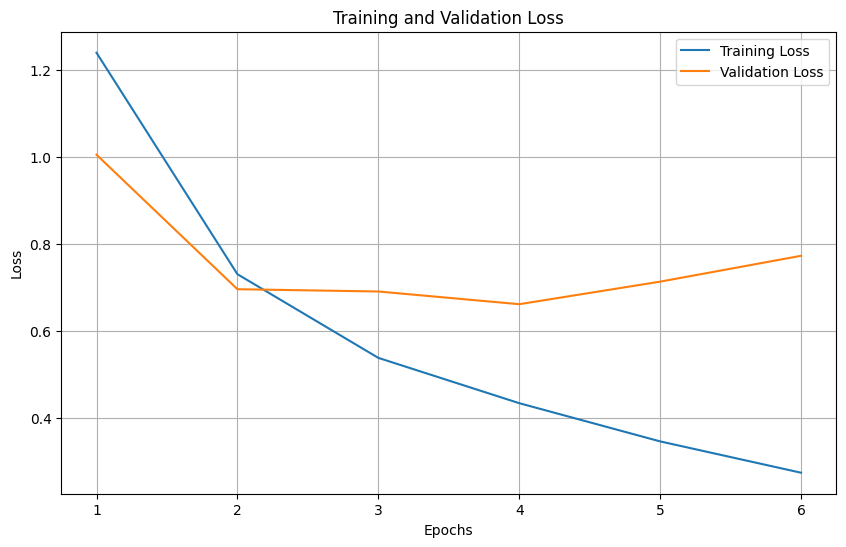

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import time

# Veri seti sınıfı
class PoetryDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.texts = data['poem_text'].values
        self.labels = data['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Text türünü kontrol et
        if not isinstance(text, str):
            raise ValueError(f"Invalid text type at index {idx}: {type(text)} - {text}")

        tokens = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Veri dosyalarının yollarını belirtin
train_file = "/content/drive/MyDrive/30_data_set/30_train/sorted_final_merged_train.xlsx"
test_file = "/content/drive/MyDrive/30_data_set/30_test/sorted_final_merged_test.xlsx"

# Veri setlerini yükleme
train_data = pd.read_excel(train_file)
test_data = pd.read_excel(test_file)

# Boş veya NaN değerleri temizle
train_data = train_data.dropna(subset=['poem_text'])
test_data = test_data.dropna(subset=['poem_text'])

# Sütundaki tüm değerleri string'e çevir
train_data['poem_text'] = train_data['poem_text'].astype(str)
test_data['poem_text'] = test_data['poem_text'].astype(str)

# Electra Tokenizer ve Model
tokenizer = AutoTokenizer.from_pretrained("dbmdz/electra-base-turkish-cased-discriminator")
model = AutoModelForSequenceClassification.from_pretrained("dbmdz/electra-base-turkish-cased-discriminator", num_labels=5)

# Veri kümeleri ve veri yükleyiciler
max_len = 512
train_dataset = PoetryDataset(train_data, tokenizer, max_len)
test_dataset = PoetryDataset(test_data, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Eğitim ayarları
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early stopping parametreleri
patience = 2
best_val_loss = float('inf')
patience_counter = 0

# Eğitim süresini ölçmek için zaman damgası
start_training_time = time.time()

# Eğitim döngüsü
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    start_epoch_time = time.time()  # Epoch süresi ölçümü başlangıcı

    # Eğitim
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # İleri geçiş
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Geri yayılım ve optimizasyon
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Doğrulama
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    epoch_time = time.time() - start_epoch_time  # Epoch süresi hesaplama

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Epoch Time: {epoch_time:.2f} seconds")

    # Early stopping kontrolü
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

end_training_time = time.time()
total_training_time = end_training_time - start_training_time
print(f"Toplam Eğitim Süresi: {total_training_time:.2f} saniye")

# Çıkarım süresini ölçmek için zaman damgası
inference_start_time = time.time()

# Çıkarım işlemleri
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

inference_end_time = time.time()
inference_time = inference_end_time - inference_start_time
print(f"Çıkarım Süresi: {inference_time:.2f} saniye")

# Eğitim ve doğrulama kayıplarını görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Modeli ve tokenizer'ı Google Drive'a kaydetme
import os

save_dir = "/content/drive/MyDrive/best_electra-base-turkish-cased-discriminator"
model_name = "electra_turkish_poetry_classifier"
os.makedirs(os.path.join(save_dir, model_name), exist_ok=True)
model.save_pretrained(os.path.join(save_dir, model_name))
tokenizer.save_pretrained(os.path.join(save_dir, model_name))
print(f"Model and tokenizer have been saved to {os.path.join(save_dir, model_name)}")


Model and tokenizer have been saved to /content/drive/MyDrive/best_electra-base-turkish-cased-discriminator/electra_turkish_poetry_classifier


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

# Test veri kümesindeki gerçek etiketler ve tahmin edilen etiketler
true_labels = []
predictions = []

# Modelin değerlendirme modu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Hesaplama fonksiyonu
def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    # Sensitivity ve Specificity için Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # AUC
    y_true_one_hot = np.eye(len(np.unique(y_true)))[y_true]
    y_pred_one_hot = np.eye(len(np.unique(y_pred)))[y_pred]
    auc = roc_auc_score(y_true_one_hot, y_pred_one_hot, average="weighted", multi_class="ovr")

    return {
        "accuracy": acc,
        "recall": recall,
        "precision": precision,
        "f1_score": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc": auc
    }

# Metrikleri hesapla
results = calculate_metrics(true_labels, predictions)

# Sonuçları yazdır
print("Accuracy:", results["accuracy"])
print("Precision:", results["precision"])
print("Recall (Sensitivity):", results["recall"])
print("Specificity:", results["specificity"])
print("F-Score:", results["f1_score"])
print("AUC:", results["auc"])


Accuracy: 0.782953620829943
Precision: 0.7890478941719002
Recall (Sensitivity): 0.782953620829943
Specificity: 0.9532374100719424
F-Score: 0.7847670180834446
AUC: 0.8643429774522972


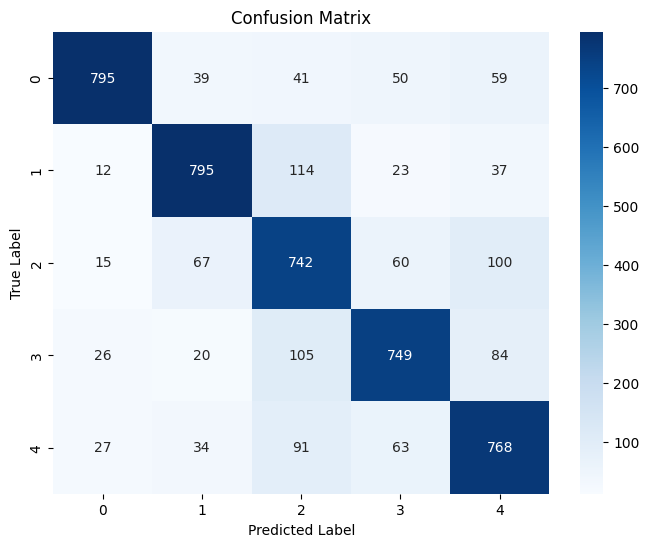

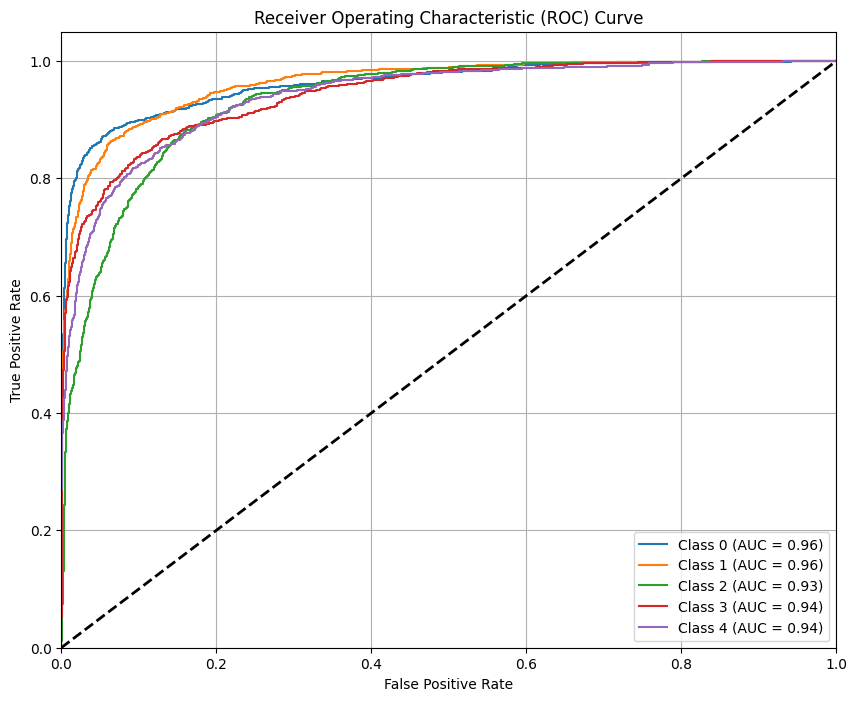

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve ve AUC
y_true_one_hot = np.eye(len(np.unique(true_labels)))[true_labels]
y_pred_probs = []

# Tahmin olasılıklarını elde etme
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        y_pred_probs.extend(probs)

y_pred_probs = np.array(y_pred_probs)

# ROC eğrilerini çizin
plt.figure(figsize=(10, 8))
for i in range(y_true_one_hot.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
# Çıkarım süresini ölçmek için zaman damgası
inference_start_time = time.time()

# Modelin çıkarım işlemleri
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

inference_end_time = time.time()
inference_time = inference_end_time - inference_start_time
print(f"Modelin çıkarım süresi: {inference_time:.2f} saniye")


Modelin çıkarım süresi: 34.62 saniye
